In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import binary_accuracy

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

C:\Users\picca\anaconda3\envs\tensor2_GAN_picca\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


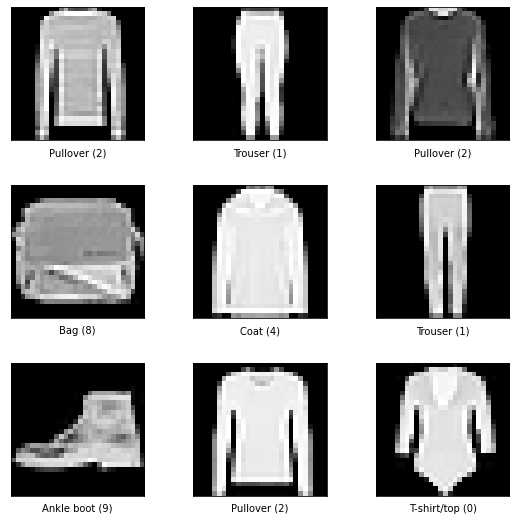

In [2]:
ds_train, ds_info = tfds.load('fashion_mnist', split= 'train', shuffle_files=True, with_info=True)
fig= tfds.show_examples(ds_train, ds_info)
batch_size = 64
image_shape = (32, 32, 1)

In [3]:
def preprocess(features):
    image = tf.image.resize(features['image'], image_shape[:2]) # [:2] h*W [:3] h*W*v
    image = tf.cast(image, tf.float32)
    image = (image-127.5) / 127.5
    return image

In [4]:
ds_train = ds_train.map(preprocess)
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size, drop_remainder=True).repeat()

In [5]:
# print(ds_info)
# print(ds_info.splits['train'])
train_num = ds_info.splits['train'].num_examples

In [6]:
train_steps_per_epoch = round(train_num/batch_size)
print(train_steps_per_epoch)

938


Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
re_lu (ReLU)                 (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         10

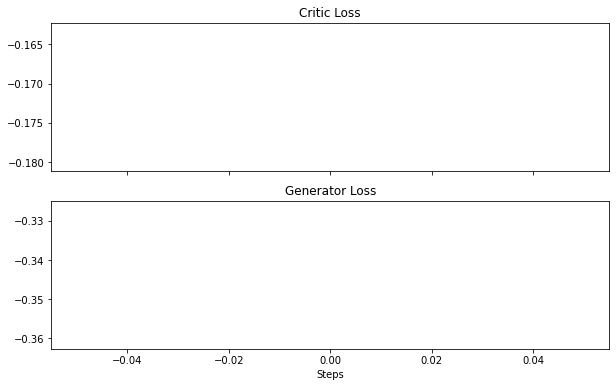

Step 100: g_loss 1.8790 , critic_loss -4.8215, critic_fake -2.2483, critic_real -3.0942, penalty 0.5211


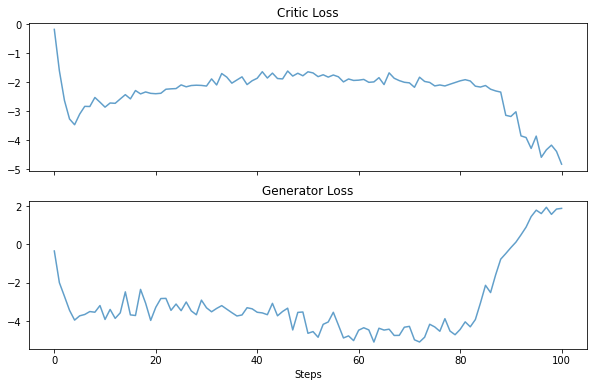

Step 200: g_loss -0.3601 , critic_loss -1.3717, critic_fake -0.6342, critic_real -0.7919, penalty 0.0544


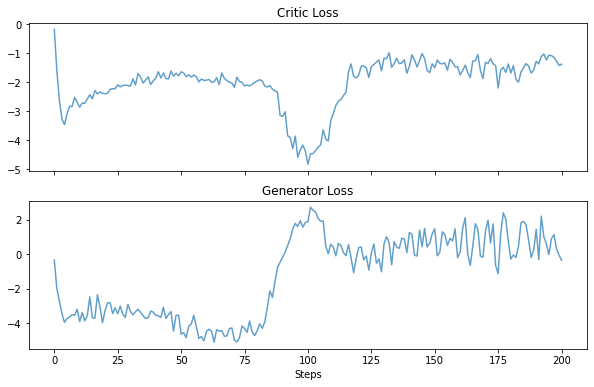

Step 300: g_loss -0.0825 , critic_loss -1.0294, critic_fake -0.0602, critic_real -0.9908, penalty 0.0216


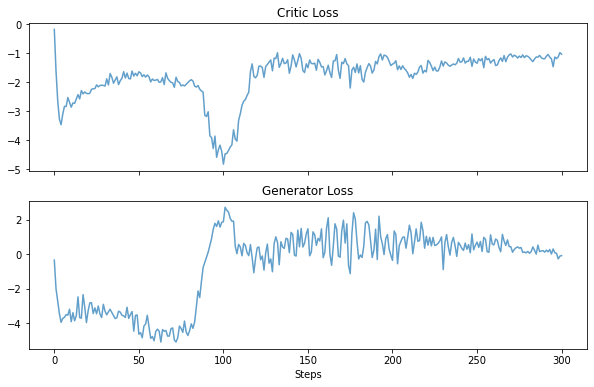

Step 400: g_loss 0.1634 , critic_loss -0.8295, critic_fake -0.2195, critic_real -0.7477, penalty 0.1378


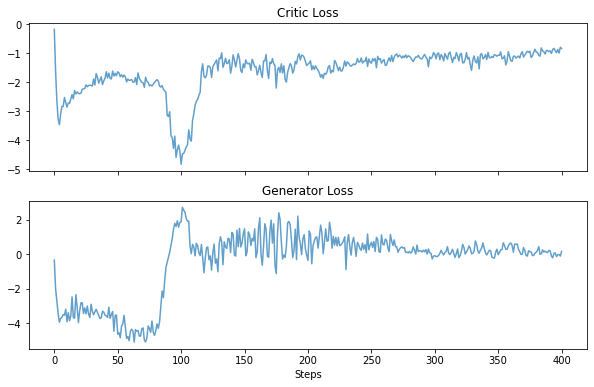

Step 500: g_loss 0.1224 , critic_loss -0.8714, critic_fake -0.4432, critic_real -0.4609, penalty 0.0328


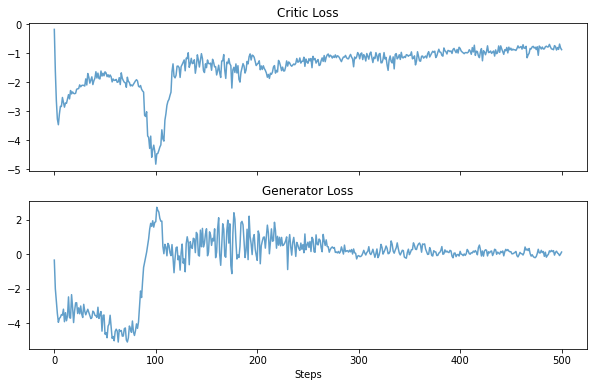

Step 600: g_loss 0.2466 , critic_loss -0.8551, critic_fake -0.3894, critic_real -0.4901, penalty 0.0244


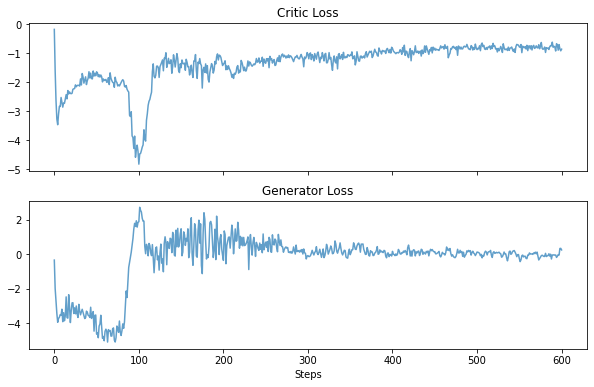

Step 700: g_loss -0.0270 , critic_loss -0.6235, critic_fake 0.1882, critic_real -0.9007, penalty 0.0890


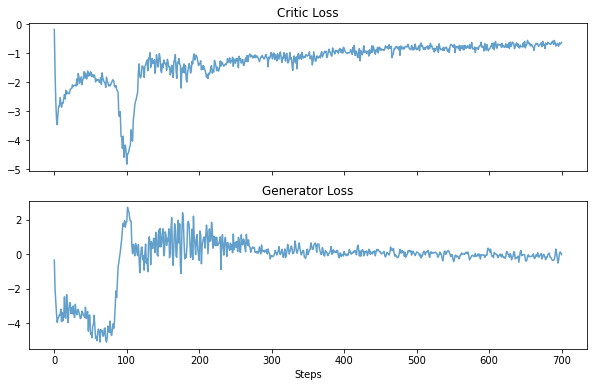

Step 800: g_loss 0.3050 , critic_loss -0.6420, critic_fake -0.5763, critic_real -0.1640, penalty 0.0983


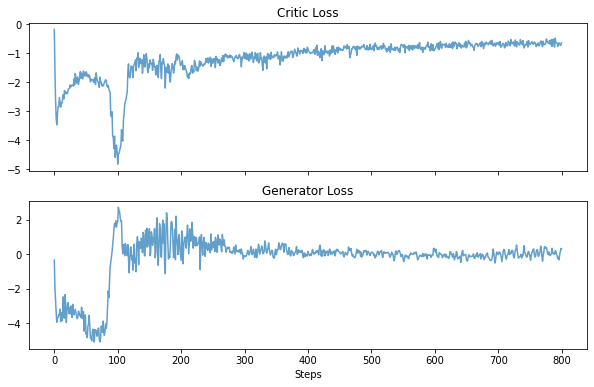

Step 900: g_loss 0.0197 , critic_loss -0.5562, critic_fake -0.0655, critic_real -0.5254, penalty 0.0347


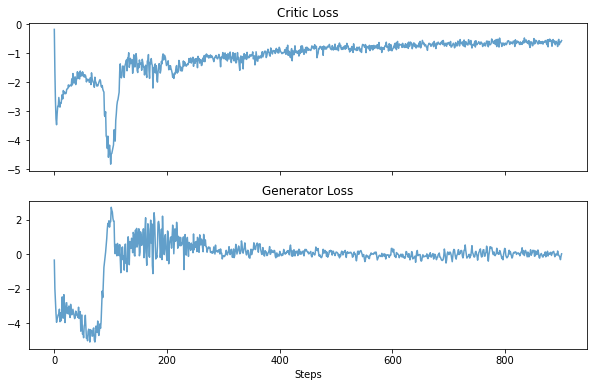

Step 1000: g_loss -0.2039 , critic_loss -0.6139, critic_fake 0.1308, critic_real -0.7548, penalty 0.0101


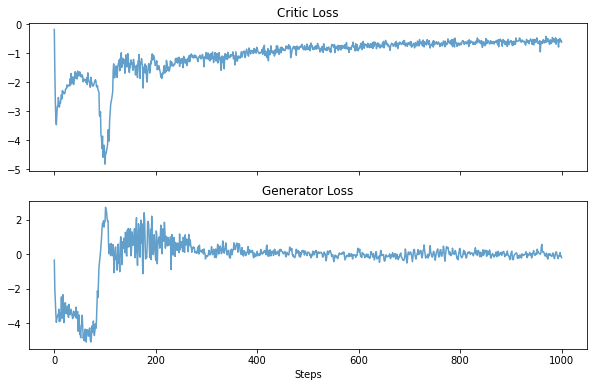

Step 1100: g_loss 0.0340 , critic_loss -0.5931, critic_fake -0.0935, critic_real -0.5716, penalty 0.0720


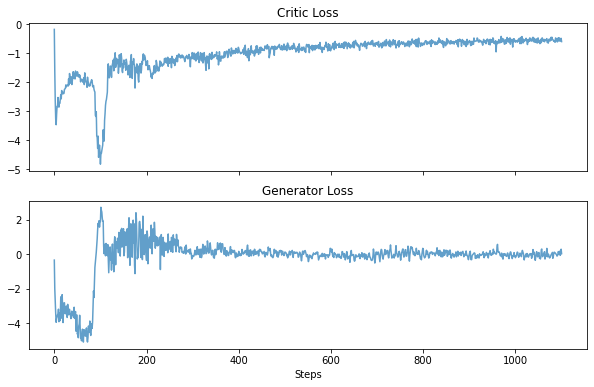

Step 1200: g_loss -0.1972 , critic_loss -0.5008, critic_fake 0.1412, critic_real -0.6420, penalty 0.0000


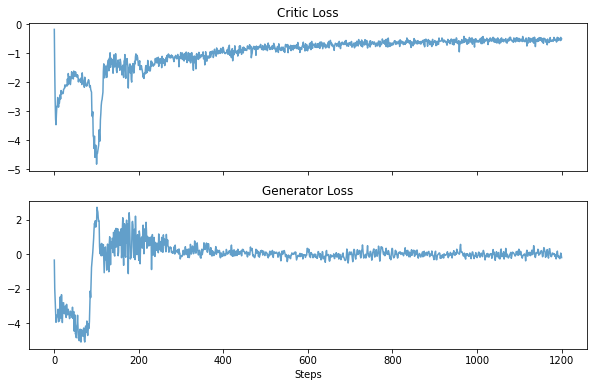

Step 1300: g_loss -0.0557 , critic_loss -0.3558, critic_fake 0.0409, critic_real -0.3977, penalty 0.0010


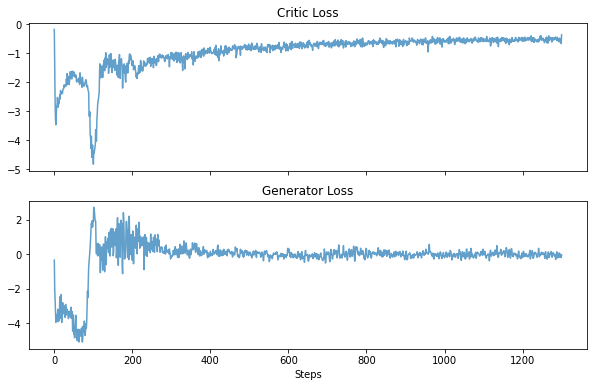

Step 1400: g_loss 0.0318 , critic_loss -0.5387, critic_fake -0.1041, critic_real -0.4486, penalty 0.0140


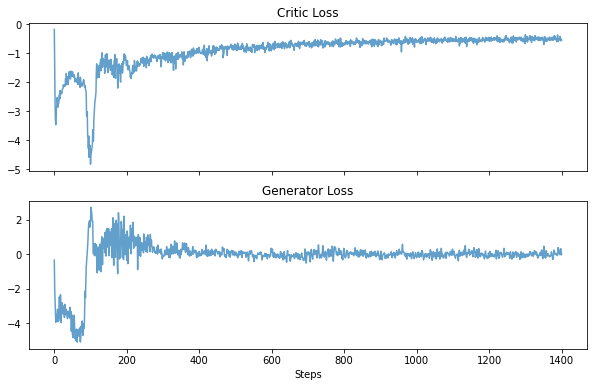

Step 1500: g_loss -0.2618 , critic_loss -0.4778, critic_fake 0.1881, critic_real -0.6676, penalty 0.0017


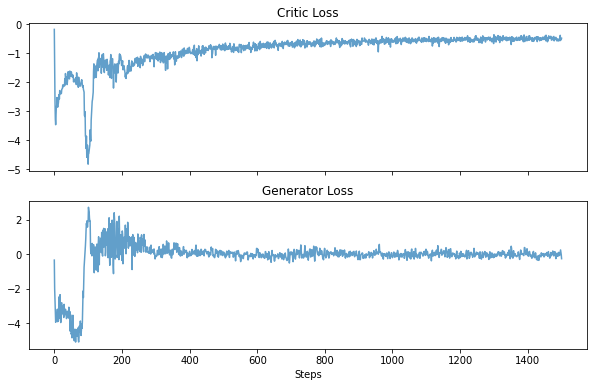

Step 1600: g_loss 0.1346 , critic_loss -0.4270, critic_fake -0.0725, critic_real -0.3661, penalty 0.0116


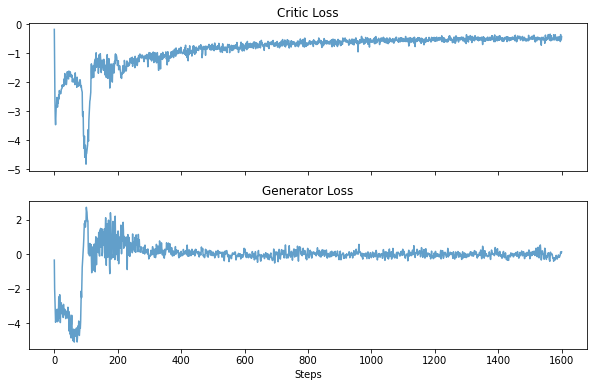

Step 1700: g_loss 0.4385 , critic_loss -0.4912, critic_fake -0.4331, critic_real -0.0581, penalty 0.0000


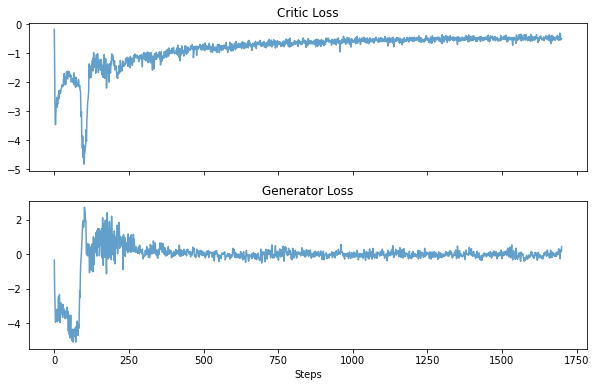

Step 1800: g_loss 0.1824 , critic_loss -0.6232, critic_fake -0.2521, critic_real -0.3720, penalty 0.0009


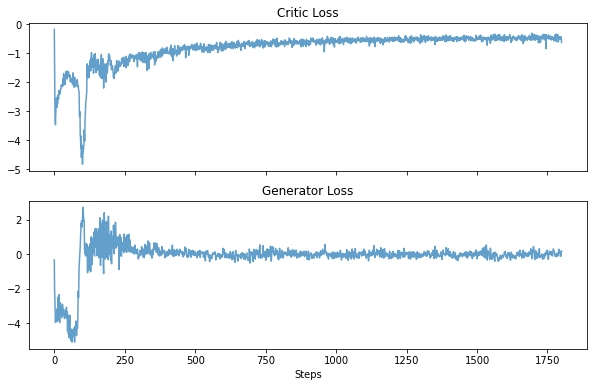

Step 1900: g_loss -0.0860 , critic_loss -0.4462, critic_fake 0.0720, critic_real -0.5189, penalty 0.0006


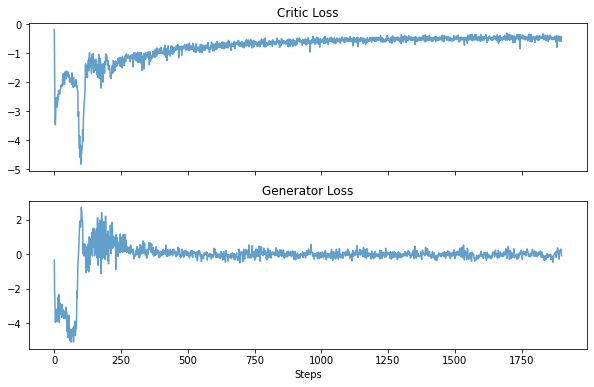

In [7]:
""" 
WGAN-GP 
"""
class WGAN_GP():
    def __init__(self, input_shape):
        self.z_dim = 128
        self.input_shape = input_shape

        self.loss_critic_real = {}
        self.loss_critic_fake = {}
        self.loss_critic = {}
        self.loss_generator = {}
        self.wgan_gradient_penalty = {}

        # critic
        self.n_critic = 5
        self.penalty_const = 10
        self.critic = self.build_critic()
        self.critic.trainable = False
        # RMSprop for wgan but Adam for wgan-gp : self.optimizer_critic =  RMSprop(5e-5)
        self.optimizer_critic = Adam(1e-4, 0.5, 0.9)
        
        # build generator pipeline  with frozen critic
        self.generator = self.build_generator()
        critic_output = self.critic(self.generator.output)
        self.model = Model(self.generator.input, critic_output)
        self.model.compile(loss=self.wasserstein_loss, optimizer=Adam(1e-4, 0.5, 0.9))
        self.critic.trainable = True

    def wasserstein_loss(self, y_true, y_pred):
        w_loss = -tf.reduce_mean(y_true*y_pred)
        return w_loss

    # generator model
    def build_generator(self):
    
        DIM = 128
        # model = tf.keras.Sequential([layers.xxx, layers.xxxxx,], name='')
        model = tf.keras.Sequential(name='Generator') 

        model.add(layers.Input(shape=[self.z_dim])) 

        model.add(layers.Dense(4*4*4*DIM))
        model.add(layers.BatchNormalization()) 
        model.add(layers.ReLU())
        model.add(layers.Reshape((4,4,4*DIM))) 

        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))
        model.add(layers.Conv2D(2*DIM, 5, padding='same')) 
        model.add(layers.BatchNormalization()) 
        model.add(layers.ReLU())

        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))
        model.add(layers.Conv2D(DIM, 5, padding='same')) 
        model.add(layers.BatchNormalization()) 
        model.add(layers.ReLU())

        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))       
        model.add(layers.Conv2D(image_shape[-1], 5, padding='same', activation='tanh')) 

        return model

    # critic model/descriminator model
    def build_critic(self):
        DIM = 128
        model = tf.keras.Sequential(name= 'critics')
        
        model.add(layers.Input(shape=self.input_shape))

        model.add(layers.Conv2D(1*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Conv2D(2*DIM, 5, strides=2, padding='same', use_bias=False))
        # model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Conv2D(4*DIM, 5, strides=2, padding='same', use_bias=False))
        # model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Flatten())
        model.add(layers.Dense(1))

        return model

    # gradient loss
    def gradient_loss(self, grad):
        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=np.arange(1, len(loss.shape)))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss - 1))
        loss = self.penalty_const * loss
        return loss

    # train critic model
    def train_critic(self, real_images, batch_size):
        
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)

        g_input = tf.random.normal((batch_size, self.z_dim))
        fake_images = self.generator.predict(g_input)

        with tf.GradientTape() as gradient_tape, tf.GradientTape() as total_tape:

            # forward pass
            pred_fake = self.critic(fake_images)
            pred_real = self.critic(real_images)

            # calculate losses
            loss_fake = self.wasserstein_loss(fake_labels, pred_fake)
            loss_real = self.wasserstein_loss(real_labels, pred_real)

            # gradient penalty
            epsilon = tf.random.uniform((batch_size, 1, 1, 1))
            interpolates = epsilon * real_images + (1 - epsilon) * fake_images
            gradient_tape.watch(interpolates)

            critic_interpolates = self.critic(interpolates)
            gradients_interpolates = gradient_tape.gradient(critic_interpolates, [interpolates])
            gradient_penalty = self.gradient_loss(gradients_interpolates)

            
            total_loss = loss_fake + loss_real + gradient_penalty

            # apply gradients
            gradients = total_tape.gradient(total_loss, self.critic.trainable_variables)

            self.optimizer_critic.apply_gradients(zip(gradients, self.critic.trainable_variables))
        
        return loss_fake, loss_real, gradient_penalty
        
        # diffrences with wgan
        # for layer in self.critic.layers:
        #     weights = layer.get_weights()
        #     weights = [tf.clip_by_value(w, -0.01, 0.01) for w in weights]
        #     layer.set_weights(weights)
        
        # return loss_fake, loss_real

    # train generator
    def train(self, data_generator, batch_size, steps, interval = 200):
        
        val_g_input = tf.random.normal((batch_size, self.z_dim))
        real_labels = tf.ones(batch_size)

        for i in range(steps):
            for _ in range (self.n_critic):
                real_images = next(data_generator)
                loss_fake, loss_real, gradient_penalty = self.train_critic(real_images, batch_size)
                critic_loss = loss_fake + loss_real + gradient_penalty

            # train generator
            g_input = tf.random.normal((batch_size, self.z_dim))
            g_loss = self.model.train_on_batch(g_input, real_labels)

            self.loss_critic_real[i] = loss_real.numpy()
            self.loss_critic_fake[i] = loss_fake.numpy()
            self.wgan_gradient_penalty[i] = gradient_penalty.numpy()
            self.loss_critic[i] = critic_loss.numpy()
            self.loss_generator[i] = g_loss

            if i%interval == 0:
                msg = "Step {}: g_loss {:.4f} , critic_loss {:.4f}, critic_fake {:.4f}, critic_real {:.4f}, penalty {:.4f}"\
                    .format(i, g_loss, critic_loss, loss_fake, loss_real, gradient_penalty)
                print(msg)

                fake_images = self.generator.predict(val_g_input)
                self.plot_images(fake_images)
                self.plot_losses()


    def plot_images(self, images):
        grid_row = 1
        grid_col = 8
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_row * 2.5, grid_col*2.5))

        for row in range(grid_row):
            for col in range(grid_col):
                if self.input_shape[-1] == 1:
                    axarr[col].imshow(images[col,:,:,0]*0.5 + 0.5, cmap='gray')
                else:
                    axarr[col].imshow(images[col]*0.5 + 0.5)
                axarr[col].axis('off')
        plt.show()

    def plot_losses(self):
        fig, (ax1, ax2) = plt.subplots(2, sharex=True)
        fig.set_figwidth(10)
        fig.set_figheight(6)
        ax1.plot(list(self.loss_critic.values()), label='Critic Loss', alpha=0.7)
        ax1.set_title('Critic Loss')
        ax2.plot(list(self.loss_generator.values()), label='Generator Loss', alpha=0.7)
        ax2.set_title('Generator Loss')

        plt.xlabel('Steps')
        plt.show()


wgan_gp = WGAN_GP(image_shape)

wgan_gp.generator.summary()

wgan_gp.critic.summary()

wgan_gp.train(iter(ds_train), batch_size, 2000, 100)
# wgan_gp.train(iter(ds_train), batch_size, 200, 100)

z = tf.random.normal((8, 128))
generated_images = wgan_gp.generator.predict(z)
wgan_gp.plot_images(generated_images)

wgan_gp.generator.save_weights('./wgan_gp_models_practice/wgan_gp_fashion_mnist_1/wgan_gp_fashion_mnist_1.weights')
        

